<a href="https://colab.research.google.com/github/ceccaroni1884368/CLC_Project_2020/blob/master/Face_To_BMI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Install and Import Libraries

In [2]:
! pip install autocrop -q
! pip install facenet-pytorch -q

In [3]:
import os
from bs4 import BeautifulSoup
import requests
import autocrop
from tqdm import tqdm
import pandas as pd
import shutil
from PIL import Image
import matplotlib.pyplot as plt
import autocrop
import torch
from facenet_pytorch import MTCNN, InceptionResnetV1

# Dataset

Per creare il dataset viene eseguito uno web scraping del sito https://compareceleb.com/ e vengono salvati i valori dell'altezza (H) in cm del peso (W) in kg e viene scaricata l'immagine contenente il volto.

Successivamente viene calcolato il BMI con la formula

$$
BMI = \frac{ W }{(H / 100)^2}
$$


In [4]:
with open(os.path.join('.', 'pages_list.txt')) as f:
    pages_list = f.read().splitlines()

output_dir = os.path.join('.', 'dataset')
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

In [4]:
images = []
heights = []
weights = []

for i in tqdm(range(len(pages_list))):
    html_page = requests.get(pages_list[i])
    soup = BeautifulSoup(html_page.text, "html.parser")

    # image
    for x in soup.findAll('img'):
        if '.jpg' in x['src']:
            images.append(x['src'])
            break

    # height and weight
    h = False
    w = False
    for x in soup.findAll('td'):
        if h:
            heights.append(float(x.text.split()[0]))
        if w:
            weights.append(float(x.text.split()[0]))

        if 'Height' in x.text:
            h = True
            w = False 
        elif 'Weight' in x.text:
            h = False
            w = True
        else:
            h = False
            w = False
            
    l = min([len(images), len(heights), len(weights)])
    images = images[:l]
    heights = heights[:l]
    weights = weights[:l]

100%|██████████| 2001/2001 [20:55<00:00,  1.59it/s]


In [5]:
df = pd.DataFrame({'image':images, 'height (cm)': heights, 'weight (kg)': weights})
df.head()

,image,height (cm),weight (kg)
0,https://compareceleb.com/uploads/posts/2017-04...,167.0,66.0
1,https://compareceleb.com/uploads/posts/2018-08...,163.0,58.0
2,https://compareceleb.com/uploads/posts/2018-08...,166.0,56.0
3,https://compareceleb.com/uploads/posts/2018-08...,168.0,54.0
4,https://compareceleb.com/uploads/posts/2018-08...,180.3,84.0


In [6]:
images_path = os.path.join(output_dir, 'images')
if not os.path.exists(images_path):
    os.makedirs(images_path)

for image in tqdm(df['image']):
    response = requests.get(image)

    file = open(os.path.join(output_dir, 'images',image.split('/')[-1].split('_')[0]+ '.jpg'), "wb")
    file.write(response.content)
    file.close()

100%|██████████| 1973/1973 [14:53<00:00,  2.21it/s]


In [7]:
df['image'] = df['image'].apply(lambda x: x.split('/')[-1].split('_')[0] + '.jpg')

In [8]:
with open(os.path.join('.', 'list_images.txt')) as f:
    list_images = f.read().splitlines()

In [9]:
df = df[df['image'].isin(list_images)]
df = df.reset_index(drop=True)
df.to_csv(os.path.join(output_dir, 'df.csv'), index=False)

In [6]:
df = pd.read_csv(os.path.join(output_dir, 'df.csv'))

In [7]:
df['BMI'] = df['weight (kg)'] / (df['height (cm)'] /100)**2
df.head()

,image,height (cm),weight (kg),BMI
0,1491379716.jpg,167.0,66.0,23.665244
1,1533303278.jpg,163.0,58.0,21.829952
2,1533305289.jpg,166.0,56.0,20.322253
3,1533306129.jpg,168.0,54.0,19.132653
4,1533306989.jpg,180.3,84.0,25.839722


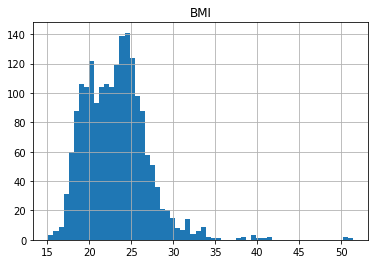

In [8]:
df[['BMI']].hist(bins=60)
plt.show()

I soggetti vengono poi classificati come **underweight** se  $BMI < 18.5$, **normal** se $18.5 \le BMI < 25$, **overweight** se $25 \le BMI < 30$,
**moderately obese** se $30 \le BMI < 35$, **severely obese** se $35 \le BMI < 40$ e **very severely obese** se $BMI >= 40$.

In [9]:
def bmi_classification(bmi):
    if bmi < 18.5:
        return 'underweight'
    elif (bmi >= 18.5) and (bmi < 25):
        return 'normal'
    elif (bmi >= 25) and (bmi < 30):
        return 'overweight'
    elif (bmi >= 30) and (bmi < 35):
        return 'moderately obese'
    elif (bmi >= 35) and (bmi < 40):
        return 'severely obese'
    else:
        return 'very severely obese'

In [10]:
df['class'] = df['BMI'].apply(bmi_classification)

In [11]:
df['class'].value_counts()

normal                 1221
overweight              457
underweight             161
moderately obese         58
very severely obese       7
severely obese            7
Name: class, dtype: int64

class | number
------|-------
underweight| 161 
normal| 1221
overweight| 457
moderately obese| 58
severely obese| 7
very severely obese| 7


In [12]:
mtcnn = MTCNN()
model = InceptionResnetV1(pretrained='vggface2', classify=False).eval()

In [13]:
images_features = []
images_targets = []
for i in tqdm(range(len(df['image']))):
    path = os.path.join(images_path, df['image'].iloc[i])
    img = Image.open(path)
    try:
        # Get cropped and prewhitened image tensor
        img_cropped = mtcnn(img)

        # Calculate embedding (unsqueeze to add batch dimension)
        img_embedding = model(img_cropped.unsqueeze(0))

        images_features.append(img_embedding.detach().cpu().numpy().flatten())
        images_targets.append(df['BMI'].iloc[i])
    except:
        pass

df_new = pd.DataFrame(images_features)
df_new['target'] = images_targets
df_new.to_csv(os.path.join(output_dir, 'df_features.csv'), index=False)

100%|██████████| 1911/1911 [13:45<00:00,  2.32it/s]


In [14]:
df_new = pd.read_csv(os.path.join(output_dir, 'df_features.csv'))

In [15]:
df_new

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,473,474,475,476,477,478,479,480,481,482,483,484,485,486,487,488,489,490,491,492,493,494,495,496,497,498,499,500,501,502,503,504,505,506,507,508,509,510,511,target
0,-0.028471,-0.130453,0.003422,0.026207,0.054758,-0.010963,0.067463,-0.001257,0.025006,0.013459,-0.046405,0.009653,0.055557,0.057967,-0.010518,0.055098,-0.080426,0.007287,0.016003,-0.023037,-0.077386,0.069949,0.018376,0.011975,0.012924,-0.072431,-0.059114,-0.101506,-0.019967,-0.052042,0.059195,0.052795,0.088112,-0.006731,0.078733,0.022323,0.007562,0.035845,-0.072146,-0.012514,...,0.049846,-0.038055,0.046773,-0.014872,-0.065536,0.087629,0.065342,0.000720,-0.041747,-0.032527,-0.081531,0.050887,-0.034693,0.035352,-0.038900,0.011833,-0.000612,-0.029266,-0.030287,0.091838,-0.045014,0.046868,0.001323,0.004895,0.047511,0.023782,-0.011367,0.052257,-0.054884,0.029280,0.035506,-0.000348,0.004212,0.044798,-0.044689,0.039541,-0.028976,-0.088558,-0.012699,23.665244
1,-0.092052,0.018627,0.007877,-0.041999,-0.005861,0.038907,-0.019004,-0.022388,-0.022027,0.062294,-0.003876,0.045918,-0.037317,-0.075878,0.047064,-0.017867,0.029779,-0.007833,-0.070748,-0.030079,-0.070942,0.053401,-0.027637,0.016629,-0.019329,0.037372,-0.045800,-0.010112,0.008457,0.019493,-0.057346,0.057563,0.002163,0.005674,-0.051516,0.055615,0.014703,-0.064435,-0.003139,0.023917,...,0.026717,-0.013165,-0.006028,-0.011632,-0.001265,-0.005124,-0.035801,0.061926,-0.008659,0.017467,-0.045162,0.071220,-0.006333,-0.055087,-0.100227,-0.046037,-0.000901,-0.033449,0.020763,0.003958,0.003150,0.014266,-0.056904,-0.049141,-0.003196,-0.031207,0.068938,-0.097217,0.006730,0.028291,0.034134,0.047746,0.000396,-0.048632,0.004430,0.109743,-0.018073,-0.000559,0.009812,21.829952
2,-0.018705,0.072215,0.007546,-0.095771,0.021259,0.057257,-0.062290,0.016131,0.039233,0.001925,-0.059607,0.042652,0.008355,-0.045719,-0.011055,-0.011898,0.022722,-0.058477,-0.073742,-0.055248,-0.060769,0.080319,0.034011,0.038355,0.007856,0.024356,0.002261,0.016015,-0.040430,0.007524,-0.060169,0.060637,0.031955,-0.032345,-0.012959,0.087907,0.058439,-0.007256,-0.009601,-0.050376,...,0.035192,-0.018639,-0.014995,0.013569,-0.020686,-0.010287,-0.054720,0.063875,0.041881,-0.014865,-0.086650,0.006097,-0.033488,0.029950,-0.058993,-0.030917,0.030727,0.056141,0.018375,0.017032,-0.028414,-0.000716,0.001417,-0.077361,-0.006971,-0.042697,0.027709,-0.060122,0.036257,0.021823,0.008237,0.085843,-0.049708,-0.052487,-0.044679,0.081969,0.022784,0.003549,0.004035,20.322253
3,-0.017358,0.055324,-0.023903,-0.052602,-0.030108,0.013327,-0.015151,0.058731,-0.000408,0.036150,-0.003820,0.005928,-0.025573,-0.025115,0.009362,0.000933,0.047360,0.032709,-0.057080,-0.108250,0.023307,-0.002242,0.018620,0.043381,-0.009989,-0.083530,-0.064895,0.011271,-0.035838,-0.009148,-0.018304,0.004655,0.044884,-0.036144,0.007571,0.080642,0.038030,-0.043986,0.021415,-0.042445,...,-0.021806,0.001000,-0.052518,-0.063584,0.014968,0.044935,-0.064571,0.009992,-0.043703,0.023606,-0.087894,-0.058310,0.004256,-0.008352,-0.083440,0.027324,-0.043257,0.018682,-0.049171,0.002571,-0.023714,0.007737,-0.038105,-0.021210,0.021628,-0.063713,0.060064,-0.080093,-0.014358,0.077442,0.075566,0.041063,0.027353,-0.023984,0.063414,0.044977,-0.053337,-0.082705,-0.058147,19.132653
4,0.086870,-0.054204,-0.040870,-0.082846,-0.057620,-0.001260,0.007474,-0.000883,-0.087843,0.010113,-0.010380,0.035335,0.024748,-0.017007,0.053944,-0.082208,0.024722,-0.014433,0.007435,0.009175,0.000944,-0.023711,0.065773,0.047138,0.042660,0.010646,-0.018250,0.026027,0.077195,0.034615,0.009093,-0.084705,-0.052524,0.027934,-0.000151,-0.040842,-0.071697,0.035392,0.034372,0.013245,...,0.009833,0.006157,-0.015027,0.075037,-0.058522,-0.052540,0.030310,0.045348,0.031488,0.026857,0.009538,-0.013102,-0.004044,-0.039061,0.009824,0.021131,0.015023,-0.093279,-0.017715,-0.035465,-0.022495,0.023429,0.021882,-0.034307,0.039946,-0.035032,0.046141,-0.009097,-0.062

In [24]:
X = df_new.drop('target', axis=1).to_numpy()
y = df_new['target'].to_numpy()

In [27]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [28]:
from sklearn.svm import SVR
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

In [30]:
regr = make_pipeline(StandardScaler(), SVR(C=1.0, epsilon=0.2))

In [31]:
regr.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('standardscaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('svr',
                 SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.2,
                     gamma='scale', kernel='rbf', max_iter=-1, shrinking=True,
                     tol=0.001, verbose=False))],
         verbose=False)

In [35]:
import sklearn
sklearn.metrics.mean_absolute_error(regr.predict(X_test), y_test)

2.036652478737237